In [1]:
# Third Party Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import os
import pickle
pandarallel.initialize(progress_bar=True)
from exphelperfunctions import abbrv_num
from exphelperfunctions import objectToFile
from exphelperfunctions import objectFromFile
from exphelperfunctions import add_value_labels

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Load original data

In [2]:
#Open CIDDS-001
dirpath = "/mnt/h/CIDDS/CIDDS-001/traffic/"
filepaths = [dirpath+f for f in os.listdir(dirpath) if f.endswith('.csv')]
print(filepaths)
dtypes = {'Date first seen': object,'Duration': np.float64, 'Proto': object, 'Src IP Addr': object, 'Src Pt': np.int32, \
          'Dst IP Addr': object, 'Dst Pt': np.float32, 'Packets': np.int64, 'Bytes': object, 'Flows': np.int32, \
          'class': object, 'attackType': object, 'attackID': object}

#Open as external server dataframe and internal (openstack) server to maintain traffic distributions
df_ext = pd.concat([pd.read_csv(f, sep=',', header=0, dtype=dtypes, skipinitialspace=True) for f in list(filepaths[i] for i in range(0,4))], ignore_index= True)
df_int = pd.concat([pd.read_csv(f, sep=',', header=0, dtype=dtypes, skipinitialspace=True) for f in list(filepaths[i] for i in range(4,8))], ignore_index= True)

['/mnt/h/CIDDS/CIDDS-001/traffic/CIDDS-001-external-week1.csv', '/mnt/h/CIDDS/CIDDS-001/traffic/CIDDS-001-external-week2.csv', '/mnt/h/CIDDS/CIDDS-001/traffic/CIDDS-001-external-week3.csv', '/mnt/h/CIDDS/CIDDS-001/traffic/CIDDS-001-external-week4.csv', '/mnt/h/CIDDS/CIDDS-001/traffic/CIDDS-001-internal-week1.csv', '/mnt/h/CIDDS/CIDDS-001/traffic/CIDDS-001-internal-week2.csv', '/mnt/h/CIDDS/CIDDS-001/traffic/CIDDS-001-internal-week3.csv', '/mnt/h/CIDDS/CIDDS-001/traffic/CIDDS-001-internal-week4.csv']


In [3]:
def fixBytesString(bytesString: str):
    splitString = bytesString.split(' ')
    if len(splitString) == 1:
        return int(splitString[0])
    elif len(splitString) == 2:
        if splitString[1] == 'M':  
            return int(float(splitString[0])*1000000)
    return -1

def fixColumns(df: pd.DataFrame):
    df['Dst Pt'] = df['Dst Pt'].astype(int)
    df['Proto'] = df['Proto'].str.strip()
    df['Bytes'] = df['Bytes'].astype(str)
    df['BytesAsInt'] = df['Bytes'].parallel_apply(fixBytesString)
    return df

In [4]:
df_ext = fixColumns(df_ext)
df_int = fixColumns(df_int)

In [5]:
# Only include normal and attacker traffic as benign vs. malicious
df_ext = df_ext.loc[(df_ext['class'] == 'normal') | (df_ext['class'] == 'attacker')]
df_int = df_int.loc[(df_int['class'] == 'normal') | (df_int['class'] == 'attacker')]

In [6]:
# Rename normal instances for multiclass classification
df_ext.loc[df_ext['attackType'] == '---','attackType'] = 'normal'
df_int.loc[df_int['attackType'] == '---','attackType'] = 'normal'
print(df_ext['attackType'].value_counts())
print(df_int['attackType'].value_counts())

normal        134240
portScan       11036
bruteForce      1224
Name: attackType, dtype: int64
normal        28051906
dos            1480217
portScan        168177
pingScan          4134
bruteForce        4077
Name: attackType, dtype: int64


# Data composition
Total amount of instances = 29,855,011

## Internal
29,708,611 total instances (5.58% malicious)

## External
146,500 total instances (8.37% malicious)

# One hot encoding and mean_bytes column

In [7]:
# One hot encoding for protocol
ohe_df = pd.get_dummies(df_ext['Proto'])
df_ext = df_ext.join(ohe_df)
ohe_df = pd.get_dummies(df_int['Proto'])
df_int = df_int.join(ohe_df)

#Generate mean bytes column
df_ext['mean_bytes'] = df_ext['BytesAsInt']/df_ext['Packets']
df_int['mean_bytes'] = df_int['BytesAsInt']/df_int['Packets']
print(df_ext.head())

           Date first seen   Duration Proto    Src IP Addr  Src Pt  \
0  2017-03-14 17:43:57.172  81412.697   TCP     EXT_SERVER    8082   
1  2017-03-14 17:43:57.172  81412.697   TCP  OPENSTACK_NET   56978   
2  2017-03-14 17:43:26.135  81504.787   TCP     EXT_SERVER    8082   
3  2017-03-14 17:43:26.135  81504.787   TCP  OPENSTACK_NET   56979   
4  2017-03-14 18:17:09.005  82100.692   TCP     EXT_SERVER    8082   

     Dst IP Addr  Dst Pt  Packets   Bytes  Flows  ... Tos   class attackType  \
0  OPENSTACK_NET   56978     3057   2.1 M      1  ...   0  normal     normal   
1     EXT_SERVER    8082     4748   2.5 M      1  ...   0  normal     normal   
2  OPENSTACK_NET   56979     8639   9.1 M      1  ...   0  normal     normal   
3     EXT_SERVER    8082    12024  10.3 M      1  ...   0  normal     normal   
4  OPENSTACK_NET   51649    11012  27.2 M      1  ...   0  normal     normal   

  attackID attackDescription BytesAsInt  ICMP  TCP  UDP   mean_bytes  
0      ---               --

In [17]:
#Get input columns and corresponding label vector
#Use duration, proto OHE, packets, bytesasint, average bytes
features = ['Duration','Packets','mean_bytes','BytesAsInt','ICMP','TCP','UDP']
#Try adding ports
features.extend(['Src Pt', 'Dst Pt'])
label = 'class' #'class' or 'attackType'
skf = StratifiedKFold(n_splits=5)

In [10]:
print(df_int.loc[df_int['class'] == 'normal'].shape)
df_int.drop(index=df_int.loc[df_int['class'] == 'normal'].sample(frac=0.5).index, inplace=True)
print(df_int.loc[df_int['class'] == 'normal'].shape)

print(df_ext.loc[df_ext['class'] == 'normal'].shape)
df_ext.drop(index=df_ext.loc[df_ext['class'] == 'normal'].sample(frac=0.5).index, inplace=True)
print(df_ext.loc[df_ext['class'] == 'normal'].shape)

(28051906, 22)
(14025953, 22)
(134240, 21)
(67120, 21)


In [18]:
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
cfs = []
preds = list()
for (train_ext_idx, test_ext_idx), (train_int_idx, test_int_idx) in \
zip(skf.split(df_ext[features],df_ext['attackType']),skf.split(df_int[features], df_int['attackType'])):
    print("TRAIN:", (len(train_int_idx)+len(train_ext_idx)), "TEST:", (len(test_int_idx)+len(test_ext_idx)))
    X_train = pd.concat([df_ext[features].iloc[train_ext_idx,:],df_int[features].iloc[train_int_idx,:]], ignore_index=True)
    X_test = pd.concat([df_ext[features].iloc[test_ext_idx,:],df_int[features].iloc[test_int_idx,:]], ignore_index=True)
    y_train = pd.concat([df_ext[label].iloc[train_ext_idx],df_int[label].iloc[train_int_idx]], ignore_index=True)
    y_test = pd.concat([df_ext[label].iloc[test_ext_idx],df_int[label].iloc[test_int_idx]], ignore_index=True)
    #Apply Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5, verbose=5)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

TRAIN: 12609550 TEST: 3152388


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100
building tree 5 of 100


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   28.7s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100building tree 37 of 100

building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100building tree 48 of 100

building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.9min


building tree 68 of 100
building tree 69 of 100building tree 70 of 100

building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.3s finished


TRAIN: 12609550 TEST: 3152388


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100building tree 9 of 100

building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   32.9s


building tree 14 of 100building tree 15 of 100

building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100building tree 44 of 100

building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  3.2min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    3.8s finished


TRAIN: 12609550 TEST: 3152388


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100

building tree 4 of 100
building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   27.8s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100building tree 52 of 100

building tree 53 of 100
building tree 54 of 100
building tree 55

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.7min


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100building tree 77 of 100

building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100building tree 89 of 100

building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  4.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    3.8s finished


TRAIN: 12609551 TEST: 3152387


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100



building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   29.6s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100building tree 54 of 100

building tree 55

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.7min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    3.8s finished


TRAIN: 12609551 TEST: 3152387


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100
building tree 4 of 100

building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   26.9s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  2.8min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    4.3s finished


In [19]:
print(cfs)
print(np.shape(cfs))
cf = np.mean(cfs,axis=(0))
print(cf)
print(np.std(cfs,axis=(0)))
#objectToFile(preds, "cidds_preds_"+label)

[array([[ 332556,    1217],
       [     26, 2818589]]), array([[ 333515,     258],
       [     35, 2818580]]), array([[ 332062,    1711],
       [     15, 2818600]]), array([[ 332740,    1033],
       [      8, 2818606]]), array([[ 331234,    2539],
       [     12, 2818602]])]
(5, 2, 2)
[[3.3242140e+05 1.3516000e+03]
 [1.9200000e+01 2.8185954e+06]]
[[755.60190577 755.60190577]
 [  9.90757286   9.54148835]]


In [4]:
#Load object from file
from sklearn.metrics import confusion_matrix
label='class'
preds_mem = objectFromFile("cidds_preds_"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

In [5]:
cf = np.mean(cfs,axis=(0))
print(cf)

[[3.3174220e+05 2.0308000e+03]
 [4.4030000e+03 5.6328262e+06]]


In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
paper1_acc = 0.9990
paper1_rec = 0.999
paper1_spec = 1-0.0001
paper2_acc = 0.9705
paper2_spec = 1-0.0021
tp, fn, fp, tn = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print(np.mean(acc_scores), "\n")
print(rec_score, "\n")
print(spec_score)
print(fp / (fp+tn))

2818595.4 19.2 1351.6 332421.4
0.9995651549784192 

0.9959505412361096 

0.9999931881428556
6.811857144286416e-06


/home/arjen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


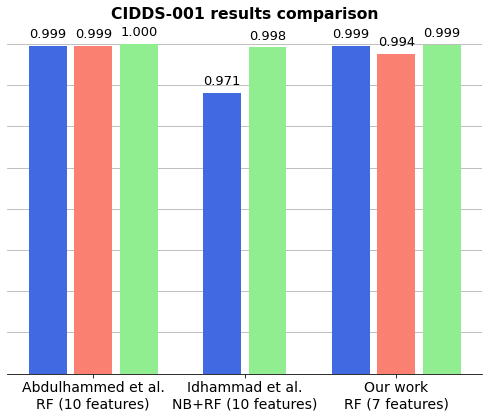

In [8]:
import matplotlib.patches as mpatches
#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['Abdulhammed et al.\nRF (10 features)', 'Idhammad et al.\nNB+RF (10 features)', 'Our work\nRF (7 features)']
x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [paper1_acc,paper1_rec,paper1_spec,paper2_acc,paper2_spec,np.mean(acc_scores),rec_score,spec_score]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0]-pad_width, height=scores[0], width=width, color=clr_acc)
plt.bar(x[0], height=scores[1], width=width, color=clr_rec)
plt.bar(x[0]+pad_width, height=scores[2], width=width, color=clr_spec)

#Spawn bar(s) of group 2
plt.bar(x[1]-pad_width/2, height=scores[3], width=width, color=clr_acc)
plt.bar(x[1]+pad_width/2, height=scores[4], width=width, color=clr_spec)

#Spawn bar(s) of group 3
plt.bar(x[2]-pad_width, height=scores[5], width=width, color=clr_acc)
plt.bar(x[2], height=scores[6], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[7], width=width, color=clr_spec)

#Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(left = False)

#Set plot details
plt.rc('font', size=13)
ax.set_xticklabels(labels)
#plt.ylabel('Metric score')
#plt.yticks(size='14')
plt.ylim([0.8, 1])
plt.xticks(size='14')
ax.set_yticklabels([])
plt.title("CIDDS-001 results comparison", fontweight='bold',  pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
#ax.legend(handles=[acc_patch,rec_patch,spec_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y')
fig.tight_layout()
plt.savefig('CIDDS_binaryclass_bars.png',bbox_inches='tight')
plt.show()

In [11]:
for cf in cfs:
    print(cf)

np.set_printoptions(suppress=True)
print('mean\n', np.mean(cfs,axis=0))
print('std. dev\n', np.std(cfs,axis=0))
print('std. dev %\n', np.divide(np.std(cfs,axis=0),np.mean(cfs,axis=0))*100)

[[ 331882    1891]
 [   4745 5632485]]
[[ 332979     794]
 [   3743 5633486]]
[[ 331479    2294]
 [   4767 5632462]]
[[ 331935    1838]
 [   4751 5632478]]
[[ 330436    3337]
 [   4009 5633220]]
mean
 [[ 331742.2    2030.8]
 [   4403.  5632826.2]]
std. dev
 [[819.97838996 819.97838996]
 [438.49743443 438.34160195]]
std. dev %
 [[ 0.24717337 40.37711197]
 [ 9.95906051  0.00778191]]


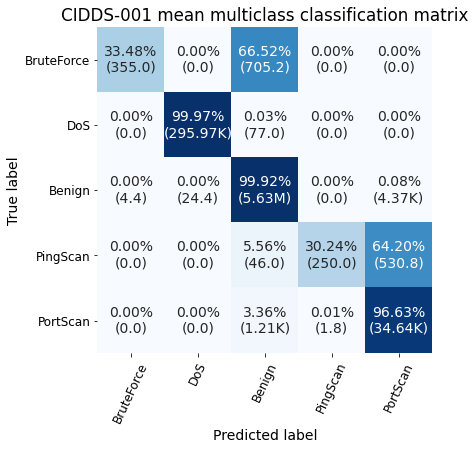

In [34]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6,6))
plt.rc('font', size=14)
#plot_confusion_matrix(rf_clf, df_test, y_test, ax=ax, normalize='true',xticks_rotation=30)
column_labels = sorted(y_test.unique())
#column_labels = ['Malicious', 'Benign']
column_labels = ['BruteForce', 'DoS', 'Benign', 'PingScan', 'PortScan']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, \
            xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0',size=12)
plt.xticks(rotation='65',size=12)
plt.title("CIDDS-001 mean multiclass classification matrix")
plt.savefig('CIDDS_multiclass_cf.png',bbox_inches='tight')
plt.show()

In [17]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: BytesAsInt, Score: 0.32722
Feature: Duration, Score: 0.26789
Feature: mean_bytes, Score: 0.24856
Feature: Packets, Score: 0.14413
Feature: UDP, Score: 0.00498
Feature: TCP, Score: 0.00486
Feature: ICMP, Score: 0.00237


## Binary importance
Feature: mean_bytes, Score: 0.33674

Feature: BytesAsInt, Score: 0.27816

Feature: Duration, Score: 0.18937

Feature: Packets, Score: 0.17305

Feature: TCP, Score: 0.01338

Feature: UDP, Score: 0.00510

Feature: ICMP, Score: 0.00420

[array([[ 331886,    1887],
       [   4746, 5632484]]), array([[ 332979,     794],
       [   3745, 5633484]]), array([[ 331478,    2295],
       [   4764, 5632465]]), array([[ 331925,    1848],
       [   4751, 5632478]]), array([[ 330436,    3337],
       [   4010, 5633219]])]

Mean

(5, 2, 2)
[[3.317408e+05 2.032200e+03]
 [4.403200e+03 5.632826e+06]]

Std. Dev.

[[819.72175767 819.72175767]
 [437.37553658 437.21893829]]



In [9]:
import math
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
fold_train_bacc = []
fold_val_bacc = []
for (train_ext_idx, test_ext_idx), (train_int_idx, test_int_idx) in \
zip(skf.split(df_ext[features],df_ext['attackType']),skf.split(df_int[features], df_int['attackType'])):
    #Split train into train/val
    extsplit_idx = math.floor(len(train_ext_idx)*0.75)
    intsplit_idx = math.floor(len(train_int_idx)*0.75)
    val_ext_idx = train_ext_idx[extsplit_idx:]
    val_int_idx = train_int_idx[intsplit_idx:]
    train_ext_idx = train_ext_idx[:extsplit_idx]
    train_int_idx = train_int_idx[:intsplit_idx]
    print("TRAIN:", (len(train_int_idx)+len(train_ext_idx)), "VAL:", (len(val_int_idx)+len(val_ext_idx)), "TEST:", (len(test_int_idx)+len(test_ext_idx)))
    #Get train / val / test split data
    X_train = pd.concat([df_ext[features].iloc[train_ext_idx,:],df_int[features].iloc[train_int_idx,:]], ignore_index=True)
    X_val = pd.concat([df_ext[features].iloc[val_ext_idx,:],df_int[features].iloc[val_int_idx,:]], ignore_index=True)
    X_test = pd.concat([df_ext[features].iloc[test_ext_idx,:],df_int[features].iloc[test_int_idx,:]], ignore_index=True)
    y_train = pd.concat([df_ext[label].iloc[train_ext_idx],df_int[label].iloc[train_int_idx]], ignore_index=True)
    y_val = pd.concat([df_ext[label].iloc[val_ext_idx],df_int[label].iloc[val_int_idx]], ignore_index=True)
    y_test = pd.concat([df_ext[label].iloc[test_ext_idx],df_int[label].iloc[test_int_idx]], ignore_index=True)
    #Apply Random Forest
    measure_search = ['gini','entropy']
    size_search = [1,5]
    msamples_search = [0.7, 0.8, 0.9]
    train_bacc_scores, val_bacc_scores = list(), list()
    for (c, n, maxs) in [(c, n, maxs) for c in measure_search for n in size_search for maxs in msamples_search]:
        print("Working on grid: ", c, n, maxs)
        clf = RandomForestClassifier(n_estimators=n,min_samples_split=10,min_samples_leaf=5,max_samples=maxs,criterion=c,n_jobs=5)
        clf.fit(X_train,y_train)
        print("Finished building random forest")
        #evaluate on train
        #ytrain_pred = clf.predict(X_train)
        #train_bacc = balanced_accuracy_score(y_train,ytrain_pred)
        #train_bacc_scores.append(train_bacc)
        #print("Finished evaluating train set")
        #evaluate on val
        yval_pred = clf.predict(X_val)
        val_bacc = balanced_accuracy_score(y_val,yval_pred)
        val_bacc_scores.append(val_bacc)
        #Print progress
        print('{%s,%.1f,%.1f} train: %.3f, val: %.3f' % (c, n, maxs, train_bacc, val_bacc))
    #fold_train_bacc.append(train_bacc_scores)
    fold_val_bacc.append(val_bacc_scores)

TRAIN: 17913006 VAL: 5971002 TEST: 5971003
Working on grid:  gini 1 0.7
Finished building random forest
Finished evaluating train set
{gini,1.0,0.7} train: 0.996, val: 0.986
Working on grid:  gini 1 0.8
Finished building random forest
Finished evaluating train set
{gini,1.0,0.8} train: 0.996, val: 0.888
Working on grid:  gini 1 0.9
Finished building random forest
Finished evaluating train set
{gini,1.0,0.9} train: 0.996, val: 0.991
Working on grid:  gini 1 1
Finished building random forest
Finished evaluating train set
{gini,1.0,1.0} train: 0.500, val: 0.500
Working on grid:  gini 5 0.7
Finished building random forest
Finished evaluating train set
{gini,5.0,0.7} train: 0.996, val: 0.991
Working on grid:  gini 5 0.8
Finished building random forest
Finished evaluating train set
{gini,5.0,0.8} train: 0.996, val: 0.988
Working on grid:  gini 5 0.9
Finished building random forest
Finished evaluating train set
{gini,5.0,0.9} train: 0.996, val: 0.992
Working on grid:  gini 5 1
Finished buildi

Finished building random forest
Finished evaluating train set
{entropy,5.0,0.7} train: 0.996, val: 0.972
Working on grid:  entropy 5 0.8
Finished building random forest
Finished evaluating train set
{entropy,5.0,0.8} train: 0.996, val: 0.987
Working on grid:  entropy 5 0.9
Finished building random forest
Finished evaluating train set
{entropy,5.0,0.9} train: 0.996, val: 0.985
Working on grid:  entropy 5 1
Finished building random forest
Finished evaluating train set
{entropy,5.0,1.0} train: 0.500, val: 0.500
TRAIN: 17913006 VAL: 5971003 TEST: 5971002
Working on grid:  gini 1 0.7
Finished building random forest
Finished evaluating train set
{gini,1.0,0.7} train: 0.996, val: 1.000
Working on grid:  gini 1 0.8
Finished building random forest
Finished evaluating train set
{gini,1.0,0.8} train: 0.998, val: 1.000
Working on grid:  gini 1 0.9
Finished building random forest
Finished evaluating train set
{gini,1.0,0.9} train: 0.998, val: 1.000
Working on grid:  gini 1 1
Finished building rando

In [20]:
print(len(fold_train_bacc))
print(len(fold_val_bacc))
a = fold_train_bacc
a = np.mean(a,axis=0)
b = fold_val_bacc
b = np.mean(b, axis=0)

5
5


In [14]:
print(np.mean(fold_val_bacc, axis=0).reshape(2,2,4))

[[[0.98662396 0.9406854  0.98710953 0.5       ]
  [0.98338637 0.98939305 0.97754219 0.5       ]]

 [[0.98646053 0.98207834 0.96972056 0.5       ]
  [0.98663282 0.99020413 0.97932739 0.5       ]]]


In [41]:
print(fold_train_bacc)
print("\n\n", fold_val_bacc)

[[0.9963092721181779, 0.9963057364456018, 0.996331889761331, 0.5, 0.9963212316834942, 0.9963257278302964, 0.9963296555762347, 0.5, 0.9963286046235402, 0.9963261025091966, 0.996329595257256, 0.5, 0.9963247244315535, 0.9963295047787877, 0.996330689134467, 0.5, 0.9963354393222118, 0.9963264168691179, 0.9963192248860084, 0.5, 0.9963312575353309, 0.9963254737893539, 0.9963374635141597, 0.5, 0.9963235099163847, 0.996335379003233, 0.9963343454450007, 0.5, 0.9963258786277435, 0.9963344359234689, 0.9963359949580484, 0.5], [0.9967421855899021, 0.9967280684296529, 0.9967460959413782, 0.5, 0.9967403121954013, 0.9967447480232245, 0.996740807512259, 0.5, 0.9967384991198791, 0.9967447480232245, 0.9967451528616141, 0.5, 0.9967409710747334, 0.9967414060726123, 0.9967448385016928, 0.5, 0.9967365816775839, 0.9967341839300135, 0.9967473707755259, 0.5, 0.9967428444692343, 0.9967484043337582, 0.9967488694911266, 0.5, 0.9967454370620461, 0.996747461253994, 0.9967470564156045, 0.5, 0.9967466817367043, 0.99674

In [28]:
print(a.reshape(2,4,4))
print("\n\n",b.reshape(2,4,4))
a_resh = a.reshape(2,4,4)
b_resh = b.reshape(2,4,4)
#print(a.reshape(2,16))

[[[0.99659652 0.99659533 0.99660712 0.5       ]
  [0.99660044 0.99660265 0.99660291 0.5       ]
  [0.99660129 0.9966051  0.99660564 0.5       ]
  [0.99660248 0.99660353 0.99660654 0.5       ]]

 [[0.99660211 0.99660263 0.99660704 0.5       ]
  [0.9966013  0.9966074  0.99660926 0.5       ]
  [0.9966057  0.99660663 0.99660893 0.5       ]
  [0.99660543 0.99660925 0.99661008 0.5       ]]]


 [[[0.98744506 0.98533491 0.98695768 0.5       ]
  [0.98712065 0.98858129 0.98906852 0.5       ]
  [0.98923099 0.98647087 0.98890612 0.5       ]
  [0.9890686  0.99004275 0.98695806 0.5       ]]

 [[0.99166569 0.98371129 0.98988018 0.5       ]
  [0.9864713  0.9876073  0.99069186 0.5       ]
  [0.98988029 0.98874388 0.98939318 0.5       ]
  [0.98939325 0.98988023 0.98955557 0.5       ]]]


# N-grams experiment

### Show amount of source IPs with more than 'threshold' flows

In [9]:
print(df_int.columns)

Index(['Date first seen', 'Duration', 'Proto', 'Src IP Addr', 'Src Pt',
       'Dst IP Addr', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Flags', 'Tos',
       'class', 'attackType', 'attackID', 'attackDescription', 'BytesAsInt',
       'ICMP', 'IGMP', 'TCP', 'UDP', 'mean_bytes'],
      dtype='object')


In [12]:
threshold = 2
vc_int = df_int['Src IP Addr'].value_counts()
res_int = df_int[df_int['Src IP Addr'].isin(vc_int[vc_int>threshold].index)]['Src IP Addr'].value_counts()
print(res_int)
vc_ext = df_ext['Src IP Addr'].value_counts()
res_ext = df_ext[df_ext['Src IP Addr'].isin(vc_ext[vc_ext>threshold].index)]['Src IP Addr'].value_counts()
print(res_ext)

192.168.220.15    2689683
DNS               1959126
192.168.220.16    1540082
192.168.210.5     1215934
192.168.200.8     1147514
                   ...   
15538_237               3
11116_6                 3
16862_24                3
16326_230               3
10250_224               3
Name: Src IP Addr, Length: 15034, dtype: int64
OPENSTACK_NET    67120
EXT_SERVER       67120
ATTACKER1         6150
ATTACKER2         5494
ATTACKER3          616
Name: Src IP Addr, dtype: int64


## Transform interesting features to N-gram representation

### df_int:

In [10]:
#Per source IP, grab N-gram and transform numerical features into new
#Done for bigrams and trigrams

features = ['Duration', 'Packets', 'BytesAsInt', 'mean_bytes']

#Create/reset columns for n_gram features
for feature in features:
    column_mean = 'ngram_' + feature + '_mean'
    column_std = 'ngram_' + feature + '_std'
    if column_mean not in df_int.columns:
        df_int[column_mean] = np.nan
    if column_std not in df_int.columns:
        df_int[column_std] = np.nan

#List of ngram features
featurelist = df_int.filter(regex='^ngram', axis=1).columns
#Window size 2 = bigrams, 3 = trigrams
winsize = 3
#Window type
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=winsize)
for itr, (srcIP, _) in enumerate(res_int.iteritems()):
    sub_df = df_int[df_int['Src IP Addr'] == srcIP]
    for feature in features:
        column_mean = 'ngram_' + feature + '_mean'
        column_std = 'ngram_' + feature + '_std'
        sub_df.loc[:,column_mean] = sub_df[feature].rolling(window=indexer, min_periods=winsize).mean()
        sub_df.loc[:,column_std] = sub_df[feature].rolling(window=indexer, min_periods=winsize).std()
    df_int.loc[:,featurelist] = df_int[featurelist].combine_first(sub_df[featurelist])
    print('Progress: ' + str(itr+1) + '/' + str(len(res_int)), end='\r')
    
    

/home/arjen/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [11]:
df_int_feather_path = "/mnt/h/CIDDS/CIDDS-001/feather/trigram_feather"
df_int.reset_index().to_feather(df_int_feather_path)

In [8]:
df_int_feather_path = "/mnt/h/CIDDS/CIDDS-001/feather/trigram_feather"
df_int = pd.read_feather(df_int_feather_path)

In [9]:
#Drop rows without ngram features
print(df_int.shape)
df_int.dropna(subset=df_int.filter(regex='^ngram', axis=1).columns, axis=0, how='any', inplace=True)
print(df_int.shape)

(29708511, 31)
(29674915, 31)


In [10]:
df_int

,index,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,...,UDP,mean_bytes,ngram_Duration_mean,ngram_Duration_std,ngram_Packets_mean,ngram_Packets_std,ngram_BytesAsInt_mean,ngram_BytesAsInt_std,ngram_mean_bytes_mean,ngram_mean_bytes_std
0,0,2017-03-15 00:01:16.632,0.000,TCP,192.168.100.5,445,192.168.220.16,58844,1,108,...,0,108.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,108.000000,0.000000,108.000000,0.000000
1,1,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888,1,108,...,0,108.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,95.333333,21.939310,95.333333,21.939310
2,2,2017-03-15 00:01:16.551,0.004,TCP,192.168.220.15,48888,192.168.100.5,445,2,174,...,0,87.000000,1.566667e-02,1.011599e-02,2.000000,0.000000,283.333333,94.685444,141.666667,47.342722
3,3,2017-03-15 00:01:16.631,0.004,TCP,192.168.220.16,58844,192.168.100.5,445,2,174,...,0,87.000000,2.666667e-03,2.309401e-03,1.666667,0.577350,140.333333,58.312377,82.333333,8.082904
4,4,2017-03-15 00:01:16.552,0.000,TCP,192.168.100.5,445,192.168.220.15,48888,1,108,...,0,108.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,95.333333,21.939310,95.333333,21.939310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29708497,31287919,2017-04-18 23:59:26.292,0.000,UDP,DNS,53,192.168.200.8,50160,1,125,...,1,125.000000,9.309683e-16,5.772463e-08,1.000000,0.000000,127.000000,1.732051,127.000000,1.732051
29708499,31287921,2017-04-18 23:59:26.292,0.000,UDP,192.168.200.8,62426,DNS,53,1,75,...,1,75.000000,3.633333e-02,6.293118e-02,4.333333,5.773502,940.666667,1499.373335,130.969697,96.942359
29708500,31287922,2017-04-18 23:59:26.291,0.000,UDP,192.168.200.8,50160,DNS,53,1,75,...,1,75.000000,3.633333e-02,6.293118e-02,4.333333,5.773502,944.666667,1495.921253,134.969697,93.670617
29708501,31287923,2017-04-18 23:59:26.295,0.109,TCP,192.168.200.8,58431,10193_14,443,11,2672,...,0,242.909091,3.633333e-02,6.293118e-02,4.333333,5.773502,948.666667,1492.445107,138.969697,90.014156


### df_ext:

In [13]:
#Per source IP, grab N-gram and transform numerical features into new
#Done for bigrams and trigrams

features = ['Duration', 'Packets', 'BytesAsInt', 'mean_bytes']

#Create/reset columns for n_gram features
for feature in features:
    column_mean = 'ngram_' + feature + '_mean'
    column_std = 'ngram_' + feature + '_std'
    if column_mean not in df_ext.columns:
        df_ext[column_mean] = np.nan
    if column_std not in df_ext.columns:
        df_ext[column_std] = np.nan

#List of ngram features
featurelist = df_ext.filter(regex='^ngram', axis=1).columns
#Window size 2 = bigrams, 3 = trigrams
winsize = 3
#Window type
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=winsize)
for itr, (srcIP, _) in enumerate(res_ext.iteritems()):
    sub_df = df_ext[df_ext['Src IP Addr'] == srcIP]
    for feature in features:
        column_mean = 'ngram_' + feature + '_mean'
        column_std = 'ngram_' + feature + '_std'
        sub_df.loc[:,column_mean] = sub_df[feature].rolling(window=indexer, min_periods=winsize).mean()
        sub_df.loc[:,column_std] = sub_df[feature].rolling(window=indexer, min_periods=winsize).std()
    df_ext.loc[:,featurelist] = df_ext[featurelist].combine_first(sub_df[featurelist])
    print('Progress: ' + str(itr+1) + '/' + str(len(res_ext)), end='\r')
    
    

/home/arjen/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [14]:
#Drop rows without ngram features
print(df_ext.shape)
df_ext.dropna(subset=df_ext.filter(regex='^ngram', axis=1).columns, axis=0, how='any', inplace=True)
print(df_ext.shape)

(146500, 29)
(146490, 29)


## Build Random Forest with ngram features

In [23]:
#Compare ngram feature set with non-ngram feature set by uncommenting feature set to be tested
features = df_int.filter(regex='^ngram', axis=1).columns
#features = ['Duration','Packets','mean_bytes','BytesAsInt','ICMP','TCP','UDP']
label = 'class' #'class' or 'attackType'
skf = StratifiedKFold(n_splits=5)

In [24]:
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
cfs = []
preds = list()
for (train_ext_idx, test_ext_idx), (train_int_idx, test_int_idx) in \
zip(skf.split(df_ext[features],df_ext['attackType']),skf.split(df_int[features], df_int['attackType'])):
    print("TRAIN:", (len(train_int_idx)+len(train_ext_idx)), "TEST:", (len(test_int_idx)+len(test_ext_idx)))
    X_train = pd.concat([df_ext[features].iloc[train_ext_idx,:],df_int[features].iloc[train_int_idx,:]], ignore_index=True)
    X_test = pd.concat([df_ext[features].iloc[test_ext_idx,:],df_int[features].iloc[test_int_idx,:]], ignore_index=True)
    y_train = pd.concat([df_ext[label].iloc[train_ext_idx],df_int[label].iloc[train_int_idx]], ignore_index=True)
    y_test = pd.concat([df_ext[label].iloc[test_ext_idx],df_int[label].iloc[test_int_idx]], ignore_index=True)
    #Apply Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100,min_samples_split=10,min_samples_leaf=5,max_samples=0.8,criterion='gini',n_jobs=5, verbose=5)
    rf_clf.fit(X_train,y_train)
    y_pred = rf_clf.predict(X_test)
    cfs.append(confusion_matrix(y_test, y_pred))
    preds.append([y_test, y_pred])

TRAIN: 12596105 TEST: 3149027


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100
building tree 4 of 100
building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   48.2s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100building tree 20 of 100

building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.1min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  7.9min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    6.3s finished


TRAIN: 12596105 TEST: 3149027


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   49.2s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100building tree 43 of 100

building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.2min


building tree 68 of 100
building tree 69 of 100building tree 70 of 100

building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  8.0min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    6.4s finished


TRAIN: 12596106 TEST: 3149026


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100
building tree 4 of 100
building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   50.2s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.2min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  8.0min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    6.2s finished


TRAIN: 12596106 TEST: 3149026


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   53.7s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.3min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  8.2min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    6.6s finished


TRAIN: 12596106 TEST: 3149026


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100




building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   53.7s


building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55

[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  5.3min


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  8.1min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:    6.1s finished


In [22]:
importance = rf_clf.feature_importances_
# summarize feature importance
for i,v in sorted(enumerate(importance),key=lambda x: x[1], reverse=True):
    print('Feature: %s, Score: %.5f' % (features[i],v))

Feature: ngram_BytesAsInt_mean, Score: 0.20894
Feature: ngram_Packets_mean, Score: 0.19248
Feature: ngram_mean_bytes_mean, Score: 0.16542
Feature: ngram_Duration_mean, Score: 0.11323
Feature: ngram_mean_bytes_std, Score: 0.10154
Feature: ngram_BytesAsInt_std, Score: 0.10119
Feature: ngram_Duration_std, Score: 0.09975
Feature: ngram_Packets_std, Score: 0.01746


## Ngram feature set results

In [26]:
print(cfs)
print(np.shape(cfs))
cf = np.mean(cfs,axis=(0))
print(cf)
print(np.std(cfs,axis=(0)))
#objectToFile(preds, "cidds_trigrams_preds_"+label)

[array([[ 325834,    7938],
       [   9130, 2806125]]), array([[ 322836,   10936],
       [  14606, 2800649]]), array([[ 324793,    8978],
       [  32569, 2782686]]), array([[ 320841,   12931],
       [    112, 2815142]]), array([[ 311153,   22619],
       [     71, 2815183]])]
(5, 2, 2)
[[ 321091.4   12680.4]
 [  11297.6 2803957. ]]
[[ 5254.94474186  5255.08563584]
 [11993.92057002 11993.5468482 ]]


In [4]:
from sklearn.metrics import classification_report, confusion_matrix
label = 'class'
preds_mem = objectFromFile("cidds_trigrams_preds_"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

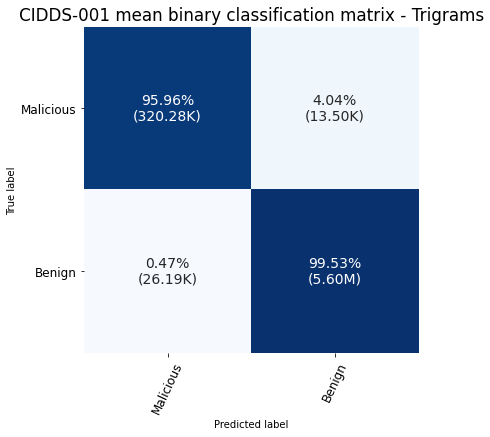

In [20]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6,6))
plt.rc('font', size=14)
#plot_confusion_matrix(rf_clf, df_test, y_test, ax=ax, normalize='true',xticks_rotation=30)
column_labels = sorted(y_test.unique())
column_labels = ['Malicious', 'Benign']
#column_labels = ['BruteForce', 'DoS', 'Benign', 'PingScan', 'PortScan']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, \
            xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0',size=12)
plt.xticks(rotation='65',size=12)
plt.title("CIDDS-001 mean binary classification matrix - Trigrams")
plt.savefig('CIDDS_binaryclass_trigrams_cf.png',bbox_inches='tight')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print('Accuracy: ' + str(np.mean(acc_scores)), "\n")
print('Recall: ' + str(rec_score), "\n")
print('Specificity: ' + str(spec_score))

321091.4 12680.4 11297.6 2803957.0
Accuracy: 0.9923855829409579 

Recall: 0.995987005935449 

Specificity: 0.9620087736591287


## Normal feature set results

In [23]:
print(cfs)
print(np.shape(cfs))
cf = np.mean(cfs,axis=(0))
print(cf)
print(np.std(cfs,axis=(0)))
objectToFile(preds, "cidds_trigrams_normal_preds_"+label)

[array([[ 331889,    1882],
       [   4742, 5625768]]), array([[ 332983,     789],
       [   3741, 5626768]]), array([[ 331478,    2294],
       [   4747, 5625762]]), array([[ 331925,    1847],
       [   4751, 5625758]]), array([[ 330437,    3335],
       [   4022, 5626487]])]
(5, 2, 2)
[[3.3174240e+05 2.0294000e+03]
 [4.4006000e+03 5.6261086e+06]]
[[820.71909933 820.75492079]
 [433.06747742 432.90996755]]


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
label = 'class'
preds_mem = objectFromFile("cidds_trigrams_normal_preds_"+label)
cfs = []
for pred_tuple in preds_mem:
    cfs.append(confusion_matrix(pred_tuple[0], pred_tuple[1]))

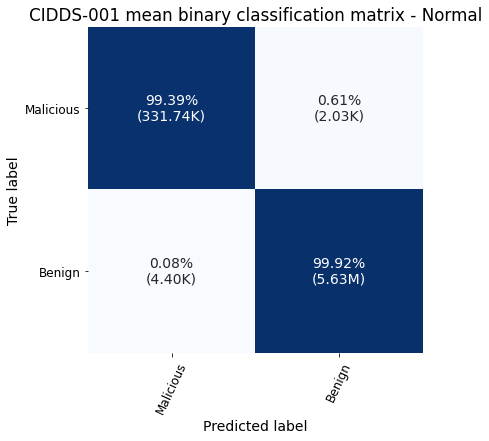

In [24]:
#Plot confusion matrix
import seaborn as sns
#labels = ['Benign','Malicious']

#Standard heatmap
cf_norm = cf/cf.sum(axis=1)[:,None]
cf_percentages = ["{0:.2%}".format(value) for value in cf_norm.flatten()]
cf_numbers = [abbrv_num(value) for value in cf.flatten()]
cf_labels = ['{v1}\n({v2})'.format(v1=v1, v2=v2) for v1,v2 in zip(cf_percentages,cf_numbers)]
cf_labels = np.asarray(cf_labels).reshape(cf.shape)

fig, ax = plt.subplots(figsize=(6,6))
plt.rc('font', size=14)
#plot_confusion_matrix(rf_clf, df_test, y_test, ax=ax, normalize='true',xticks_rotation=30)
column_labels = sorted(y_test.unique())
column_labels = ['Malicious', 'Benign']
#column_labels = ['BruteForce', 'DoS', 'Benign', 'PingScan', 'PortScan']
sns.heatmap(cf_norm, annot=cf_labels, fmt='',cmap='Blues',cbar=False, vmin=0.0, vmax=1.0, ax=ax, \
            xticklabels=column_labels, yticklabels=column_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation='0',size=12)
plt.xticks(rotation='65',size=12)
plt.title("CIDDS-001 mean binary classification matrix - Normal")
plt.savefig('CIDDS_binaryclass_trigrams_normal_cf.png',bbox_inches='tight')
plt.show()

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
tn, fp, fn, tp = np.mean(cfs,axis=0).ravel()
print(tn,fp,fn,tp)

acc_scores = [accuracy_score(pred_tuple[0], pred_tuple[1]) for pred_tuple in preds_mem]
rec_score  = tp / (tp+fn)
spec_score = tn / (tn+fp)
print('Accuracy: ' + str(np.mean(acc_scores)), "\n")
print('Recall: ' + str(rec_score), "\n")
print('Specificity: ' + str(spec_score))

331742.4 2029.4 4400.6 5626108.6
Accuracy: 0.998921915315526 

Recall: 0.999218436584741 

Specificity: 0.9939197978978451


Feature: BytesAsInt, Score: 0.30886

Feature: mean_bytes, Score: 0.27141

Feature: Duration, Score: 0.23921

Feature: Packets, Score: 0.16979

Feature: TCP, Score: 0.00435

Feature: UDP, Score: 0.00421

Feature: ICMP, Score: 0.00217

## Barplot of own feature sets

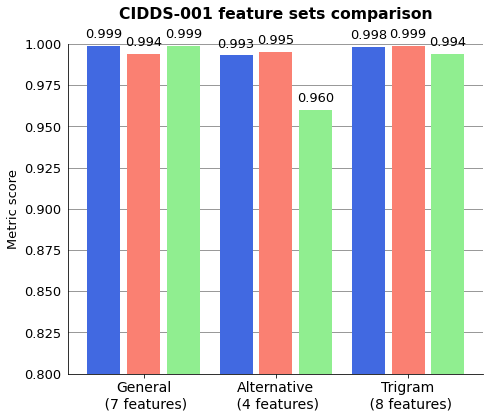

In [14]:
import matplotlib.patches as mpatches

#Scores
genset_acc = 0.999
genset_rec = 0.994
genset_spec = 0.999
trigramset_acc = 0.993
trigramset_rec = 0.995
trigramset_spec = 0.960
altset_acc = 0.998
altset_rec = 0.999
altset_spec = 0.994

#Colors
clr_acc = 'royalblue'
clr_rec = 'salmon'
clr_spec = 'lightgreen'

acc_patch = mpatches.Patch(color=clr_acc, label='accuracy')
rec_patch = mpatches.Patch(color=clr_rec, label='recall')
spec_patch = mpatches.Patch(color=clr_spec, label='specificity')

labels = ['General\n (7 features)', 'Alternative\n (4 features)', \
          'Trigram\n (8 features)']

x = np.arange(len(labels))*10
width = 2.5  # the width of the bars
pad_width = 3
scores = [genset_acc,genset_rec,genset_spec,trigramset_acc,trigramset_rec,trigramset_spec,altset_acc,altset_rec,altset_spec]

fig, ax = plt.subplots(figsize=(7,6))

#Spawn bar(s) of group 1
plt.bar(x[0]-pad_width, height=scores[0], width=width, color=clr_acc)
plt.bar(x[0], height=scores[1], width=width, color=clr_rec)
plt.bar(x[0]+pad_width, height=scores[2], width=width, color=clr_spec)

#Spawn bar(s) of group 2
plt.bar(x[1]-pad_width, height=scores[3], width=width, color=clr_acc)
plt.bar(x[1], height=scores[4], width=width, color=clr_rec)
plt.bar(x[1]+pad_width, height=scores[5], width=width, color=clr_spec)

#Spawn bar(s) of group 3
plt.bar(x[2]-pad_width, height=scores[6], width=width, color=clr_acc)
plt.bar(x[2], height=scores[7], width=width, color=clr_rec)
plt.bar(x[2]+pad_width, height=scores[8], width=width, color=clr_spec)

#Hide the left, right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)

plt.tick_params(left = False)

#Set plot details
plt.rc('font', size=13)
plt.ylabel('Metric score')
plt.yticks()
#ax.set_yticklabels([])
plt.ylim([0.8, 1])
#ax.get_yaxis().set_visible(False)
plt.xticks(size='14')
plt.title("CIDDS-001 feature sets comparison", fontweight='bold', pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels)
add_value_labels(ax)
#ax.legend(handles=[acc_patch,rec_patch,spec_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_axisbelow(True)
plt.grid(axis='y', color='grey')
fig.tight_layout()
plt.savefig('CIDDS_binaryclass_featuresets_bars.png',bbox_inches='tight')
plt.show()